<h1> DSCI 100: Group 38 Final Project </h1>

<br>
<b> Dataset title: </b> <b> <a href="https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling"> User Knowledge Modeling Data Set </a> </b>

<b> Introduction: </b> The dataset we are using is the “User Knowledge Modelling Dataset” from the UCI Machine Learning Repository in which the population consists of 403 undergraduate students in the Department of Electrical Education of Gazi University in the 2009 semester. 

<b> Dataset terminology: </b>

<b>STG</b> - The degree of study time for goal object materials

<b>SCG</b> - The degree of repetition number of user for goal object materials

<b>STR</b> - The degree of study time of user for related objects with goal object

<b>LPR</b> - The exam performance of user for related objects with goal object

<b>PEG</b> - The exam performance of user for goal objects

<b>UNS</b> - The knowledge level of user

From the raw dataset, the target value is UNS and is classified through input values: STG, SCG, STR, LPR, and PEG. Our objective is to determine the category of UNS assigned to the user based on PEG (we will discuss later why we only choose this variable as the predictor) with k-NN classification. The target value is the knowledge level of students/ ‘users’ about the subject of Electrical DC Machines in which its features is PEG and its categories are:

 - Very low
 - Low
 - Middle
 - High

Firstly, we loaded in the packages that were needed, and set the seed so that everything is reproducible for the data analysis. </i>

In [202]:
library(tidyverse)
library(readxl)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

set.seed(9999)

<br>

Now we need to choose the suitable predictor(s). We loaded the data into R by downloading the file, where we then read the training dataset. Then we selected all the variable columns from the data and mutated UNS as a factor. There was no need to wrangle the data into tidy format since it was already provided as such.
    
We assigned each UNS category a numeric value, from 1 to 4, representing the lowest level to the highest level. We can then use ggpairs function to find the correlations between all variables and UNS and choose the suitable predictors(the ones with stronger correlation with UNS would be preferred).

In [209]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", "user_modeling_data.xls")
whole_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file
                     select(STG : UNS)%>%              #select columns from STG to UNS
                     mutate(UNS = c(1,4,2,3)[as_factor(UNS)])      #change the categorical data into numeric for UNS column
head(whole_training,10)    # take a look at the first ten rows of the edited dataset

New names:
* `` -> ...7
* `` -> ...8



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.00,0.00,0.00,0.00,1
0.08,0.08,0.10,0.24,0.90,4
0.06,0.06,0.05,0.25,0.33,2
⋮,⋮,⋮,⋮,⋮,⋮
0.15,0.02,0.34,0.40,0.01,1
0.20,0.14,0.35,0.72,0.25,2
0.00,0.00,0.50,0.20,0.85,4


Now we are able to use ggpairs function to visualized the correlations between all variables with UNS.

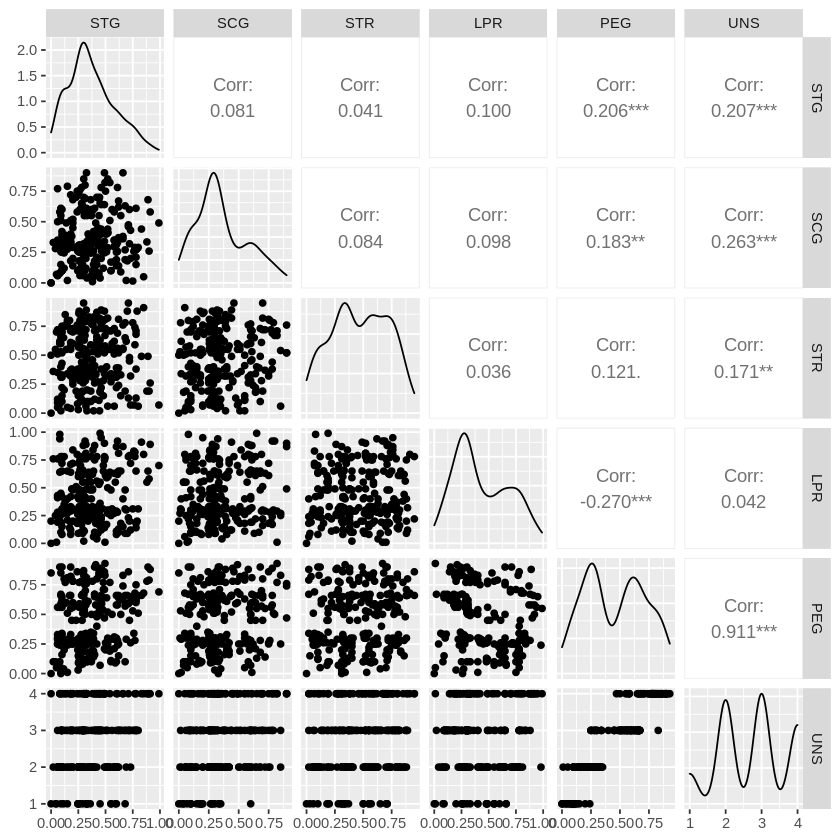

In [210]:
ggpairs(whole_training)

We can see that only PEG has a really strong positive correlation (which is 0.911) with UNS. This is why we chose PEG as the only predictor.

<br>

Now we can just select the PEG and UNS columns for both training data and testing data from the original dataset. Since we have chosen the predictor, we no longer need to keep the UNS column in a numeric form.

In [260]:
# create the training data
dataset_training <- read_excel('user_modeling_data.xls', sheet = 2)%>%     #only read the second sheet from the file
                     select(PEG,UNS)%>%              #select only predictor and target variable columns
                     mutate(UNS = as_factor(UNS))   #factorize the UNS column
head(dataset_training,10)       # take a look at the first 10 rows of the training data

# create the testing data
dataset_testing <- read_excel('user_modeling_data.xls', sheet = 3)%>%     #only read the second sheet from the file
                     select(PEG,UNS)%>%             #select only predictor and target variable columns
                     mutate(UNS = ifelse(UNS == "Very Low", "very_low", UNS))%>%   # make all the values in UNS column same for training and testing data
                     mutate(UNS = as_factor(UNS))         #factorize the UNS column
head(dataset_testing,10)    # take a look at the first 10 rows of the testing data

New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.00,very_low
0.90,High
0.33,Low
⋮,⋮
0.01,very_low
0.25,Low
0.85,High


New names:
* `` -> ...7
* `` -> ...8



PEG,UNS
<dbl>,<fct>
0.05,very_low
0.14,Low
0.85,High
⋮,⋮
0.15,Low
0.80,High
0.07,very_low


By making a table, we can see the distribution of each status in the training data in regards to their counts and percentages. </i>

In [261]:
num_UNS <- dataset_training%>%
           group_by(UNS)%>%        # group by the UNS column
           summarize(count = n(),             #calculate the number of observations for each status of UNS
                     percentage = n() / nrow(dataset_training) *100)    #calculate the percentage
num_UNS

UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


<br>

We concluded there is no missing data in the training data. </b>

In [262]:
nrow(dataset_training%>%filter(is.na(UNS)))   # find the number of rows with missing data in UNS column
nrow(dataset_training%>%filter(is.na(PEG)))   # find the number of rows with missing data in PEG column

[1] 0

[1] 0

<br>

Through R, we also calculated the average PEG score for the training data to be 0.46

In [263]:
PEGavg <- dataset_training %>%
          summarize(PEGavg = mean(PEG))   #calculate the mean PEG score
PEGavg

PEGavg
<dbl>
0.4585388


<br>

Lastly, We drew a bar plot to visualize the distribution of PEG (the exam performance of user for goal objects) over UNS (the knowledge level of user).

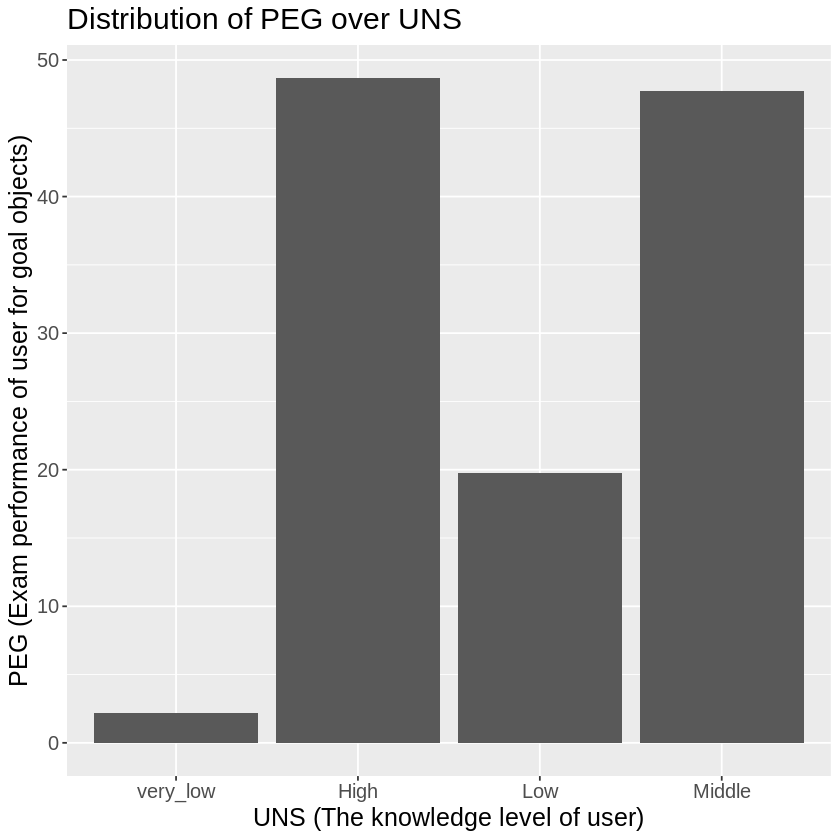

In [264]:
plot <- dataset_training %>%
         ggplot(aes(x = UNS, y = PEG)) + geom_bar(stat = "identity") + 
         labs(x = "UNS (The knowledge level of user)" , 
              y = "PEG (Exam performance of user for goal objects)") + 
         theme(text = element_text(size = 15))+
         ggtitle("Distribution of PEG over UNS")
plot

We can see from the plot that there are more users with increasing knowledge level of users. Most of the users have a middle to high level of knowledge, and the number of users with very low knowledge level is quite small.

<br>

<b> Data Analysis

We used cross validation to find the k value which gives us the highest accuracy. We can see from both the line plot and the first row of the table that k should be 11.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,multiclass,0.8405140,5,0.03641189,Preprocessor1_Model06
15,accuracy,multiclass,0.8405140,5,0.03641189,Preprocessor1_Model08
13,accuracy,multiclass,0.8367404,5,0.03589356,Preprocessor1_Model07
⋮,⋮,⋮,⋮,⋮,⋮,⋮
39,accuracy,multiclass,0.7783518,5,0.03920369,Preprocessor1_Model20
43,accuracy,multiclass,0.7783518,5,0.03920369,Preprocessor1_Model22
1,accuracy,multiclass,0.7510662,5,0.02717302,Preprocessor1_Model01


[1] 11

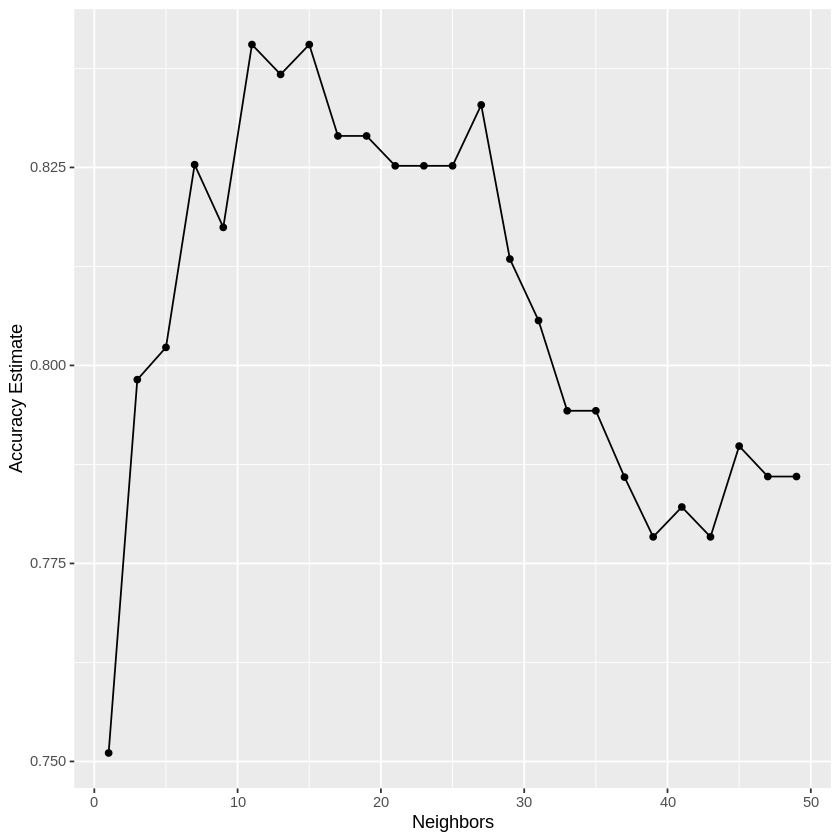

In [265]:
# Find the suitable k value using cross validation
set.seed(9999)
vfold <- vfold_cv(dataset_training, v = 5, strata = UNS)   # seperat the data into five random groups

recipe <- recipe(UNS ~ PEG, data = dataset_training) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
             set_engine("kknn") %>%
             set_mode("classification")       

wkflw <- workflow() %>%                              #create a workflow
             add_recipe(recipe) %>%
             add_model(knn_spec) 

gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))   #create the list of k values we are going to test

results <- wkflw  %>%
           tune_grid(resamples = vfold, grid = gridvals)  %>%
           collect_metrics()%>%         
           filter(.metric == "accuracy")%>%                   
           arrange(desc(mean))
results

accuracy_vs_k <- ggplot(results, aes(x = neighbors, y = mean)) +
                 geom_point() + geom_line() +
                 labs(x = "Neighbors", y = "Accuracy Estimate")

accuracy_vs_k

kmin <- results %>%           #find the k value with highest accuracy
        slice(1) %>%
        pull(neighbors)
kmin

Now as we have already calculated the most suitable k value, we just plugged it in and run the classifier.

In [270]:
set.seed(9999)
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%      # plug in the k value we found above
              set_engine("kknn") %>%      
              set_mode("classification")

knn_fit <- workflow() %>%      
           add_recipe(recipe) %>%     
           add_model(knn_spec_2) %>%  
           fit(data = dataset_training)       #fit the training data

predictions <- knn_fit %>%
               predict(dataset_testing) %>%      
               bind_cols(dataset_testing)

summary <- predictions %>%    
           metrics(truth = UNS, estimate = .pred_class) %>%
           filter(.metric == "accuracy")%>%
           select(.estimate) 
summary

ERROR: Error: In metric: `accuracy`
Problem with `summarise()` column `.estimate`.
[34mℹ[39m `.estimate = metric_fn(truth = UNS, estimate = .pred_class, na_rm = na_rm)`.
[31m✖[39m `truth` and `estimate` levels must be equivalent.
`truth`: very_low, Low, High, Middle
`estimate`: very_low, High, Low, Middle



In [ ]:

conf_mat <- predictions %>%          
            conf_mat(truth = UNS, estimate = .pred_class)
conf_mat

<br>

Overall, we expect there to be a positive correlation between high PEG values to higher categorical values of UNS such that the highest combined values should have a category of “high”. Since the initial data exploration suggested that only high PEG values contribute to a high UNS value, this would suggest that a high level of exam performance correlates to a high knowledge level about Electrical DC Machines. It would also propel further exploratory questions regarding if exam performance is an accurate indicator of knowledge regarding Electrical DC Machines. 